In [1]:
import math
import io
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np

from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt

from pytorch_msssim import ms_ssim, ssim
from compressai.zoo import bmshj2018_factorized

### Utility functions

In [2]:
def display_pil_img(img):
    plt.figure(figsize=(4, 4))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

def display_tensor_img(img):
    plt.figure(figsize=(4, 4))
    plt.axis('off')
    plt.imshow(img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
    plt.show()

In [3]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda' 
elif torch.backends.mps.is_available():
    'mps'
net = bmshj2018_factorized(quality=2, pretrained=True).eval().to(device)
print(f'Parameters: {sum(p.numel() for p in net.parameters())}')

Parameters: 2998147


### Test Compression and Reconstruction/Decompression

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

# Load the CelebA dataset
dataset = datasets.CelebA(root='./data', split='train', transform=transform, download=True)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

Files already downloaded and verified


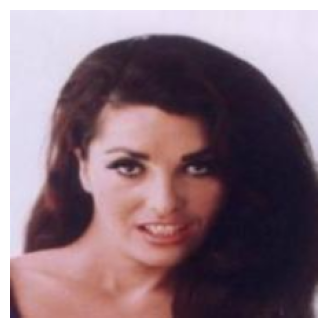

In [5]:
x = dataset[10][0].unsqueeze(0).to(device)
display_tensor_img(x)

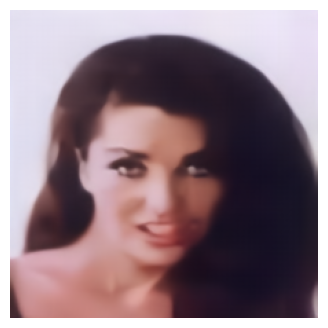

In [6]:
with torch.no_grad():
    out_net = net.forward(x)
out_net['x_hat'].clamp_(0, 1)
display_tensor_img(out_net['x_hat'])

In [7]:
from compressai.models import FactorizedPrior

class MyFactorizedPrior(FactorizedPrior):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        y = self.g_a(x)
        y_hat, y_likelihoods = self.entropy_bottleneck(y)
        x_hat = self.g_s(y_hat)

        return {
            "x_hat": x_hat,
            "y_hat": y_hat,
            "likelihoods": {
                "y": y_likelihoods,
            },
        }

In [8]:
# Copyright (c) 2021-2024, InterDigital Communications, Inc
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted (subject to the limitations in the disclaimer
# below) provided that the following conditions are met:

# * Redistributions of source code must retain the above copyright notice,
#   this list of conditions and the following disclaimer.
# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.
# * Neither the name of InterDigital Communications, Inc nor the names of its
#   contributors may be used to endorse or promote products derived from this
#   software without specific prior written permission.

# NO EXPRESS OR IMPLIED LICENSES TO ANY PARTY'S PATENT RIGHTS ARE GRANTED BY
# THIS LICENSE. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND
# CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT
# NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A
# PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR
# CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL,
# EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO,
# PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS;
# OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY,
# WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR
# OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF
# ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

from torch.hub import load_state_dict_from_url
from compressai.models import FactorizedPrior
from compressai.zoo.pretrained import load_pretrained

__all__ = [
    "bmshj2018_factorized",
    "bmshj2018_factorized_relu",
    "bmshj2018_hyperprior",
    "mbt2018",
    "mbt2018_mean",
    "cheng2020_anchor",
    "cheng2020_attn",
]

model_architectures = {
    "bmshj2018-factorized": MyFactorizedPrior
}

root_url = "https://compressai.s3.amazonaws.com/models/v1"
model_urls = {
    "bmshj2018-factorized": {
        "mse": {
            1: f"{root_url}/bmshj2018-factorized-prior-1-446d5c7f.pth.tar",
            2: f"{root_url}/bmshj2018-factorized-prior-2-87279a02.pth.tar",
            3: f"{root_url}/bmshj2018-factorized-prior-3-5c6f152b.pth.tar",
            4: f"{root_url}/bmshj2018-factorized-prior-4-1ed4405a.pth.tar",
            5: f"{root_url}/bmshj2018-factorized-prior-5-866ba797.pth.tar",
            6: f"{root_url}/bmshj2018-factorized-prior-6-9b02ea3a.pth.tar",
            7: f"{root_url}/bmshj2018-factorized-prior-7-6dfd6734.pth.tar",
            8: f"{root_url}/bmshj2018-factorized-prior-8-5232faa3.pth.tar",
        },
        "ms-ssim": {
            1: f"{root_url}/bmshj2018-factorized-ms-ssim-1-9781d705.pth.tar",
            2: f"{root_url}/bmshj2018-factorized-ms-ssim-2-4a584386.pth.tar",
            3: f"{root_url}/bmshj2018-factorized-ms-ssim-3-5352f123.pth.tar",
            4: f"{root_url}/bmshj2018-factorized-ms-ssim-4-4f91b847.pth.tar",
            5: f"{root_url}/bmshj2018-factorized-ms-ssim-5-b3a88897.pth.tar",
            6: f"{root_url}/bmshj2018-factorized-ms-ssim-6-ee028763.pth.tar",
            7: f"{root_url}/bmshj2018-factorized-ms-ssim-7-8c265a29.pth.tar",
            8: f"{root_url}/bmshj2018-factorized-ms-ssim-8-8811bd14.pth.tar",
        },
    },
}

cfgs = {
    "bmshj2018-factorized": {
        1: (128, 192),
        2: (128, 192),
        3: (128, 192),
        4: (128, 192),
        5: (128, 192),
        6: (192, 320),
        7: (192, 320),
        8: (192, 320),
    },
}

def _load_model(
    architecture, metric, quality, pretrained=False, progress=True, **kwargs
):
    if architecture not in model_architectures:
        raise ValueError(f'Invalid architecture name "{architecture}"')

    if quality not in cfgs[architecture]:
        raise ValueError(f'Invalid quality value "{quality}"')

    if pretrained:
        if (
            architecture not in model_urls
            or metric not in model_urls[architecture]
            or quality not in model_urls[architecture][metric]
        ):
            raise RuntimeError("Pre-trained model not yet available")

        url = model_urls[architecture][metric][quality]
        state_dict = load_state_dict_from_url(url, progress=progress)
        state_dict = load_pretrained(state_dict)
        model = model_architectures[architecture].from_state_dict(state_dict)
        return model

    model = model_architectures[architecture](*cfgs[architecture][quality], **kwargs)
    return model


def my_bmshj2018_factorized(
    quality, metric="mse", pretrained=False, progress=True, **kwargs
):
    r"""Factorized Prior model from J. Balle, D. Minnen, S. Singh, S.J. Hwang,
    N. Johnston: `"Variational Image Compression with a Scale Hyperprior"
    <https://arxiv.org/abs/1802.01436>`_, Int Conf. on Learning Representations
    (ICLR), 2018.

    Args:
        quality (int): Quality levels (1: lowest, highest: 8)
        metric (str): Optimized metric, choose from ('mse', 'ms-ssim')
        pretrained (bool): If True, returns a pre-trained model
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    if metric not in ("mse", "ms-ssim"):
        raise ValueError(f'Invalid metric "{metric}"')

    if quality < 1 or quality > 8:
        raise ValueError(f'Invalid quality "{quality}", should be between (1, 8)')

    return _load_model(
        "bmshj2018-factorized", metric, quality, pretrained, progress, **kwargs
    )

In [9]:
# Load network
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = my_bmshj2018_factorized(quality=2, pretrained=True).eval().to(device)
print(f'Parameters: {sum(p.numel() for p in net.parameters())}')

Parameters: 2998147


### Run Attack

In [10]:
net = net.train()

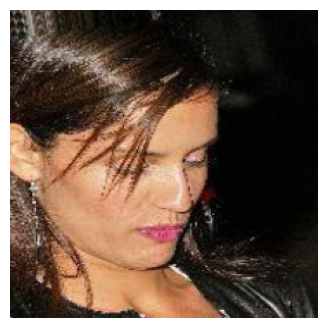

In [11]:
x_hat = dataset[3][0].unsqueeze(0).to(device)
x_orig = x_hat.clone(); x_hat.requires_grad = True
display_tensor_img(x_hat)

In [12]:
def loss_fn(x_emb, y_emb, x_img, y_img, lamb=0.5):
    embedding_loss = F.mse_loss(x_emb, y_emb)
    image_loss =  F.mse_loss(x_img, y_img)
    quality_loss = 1 - ssim(x_img, y_img, data_range=1, size_average=True)
    return embedding_loss + lamb * (image_loss + quality_loss)

In [13]:
def pgd(src_img, target_img, model, iters):
    optimizer = torch.optim.Adam([target_img], lr=0.01)

    # Get the embedding of the source image
    src_emb = model.forward(src_img)['y_hat']
    target_baseline = target_img.clone()

    pbar = tqdm(range(iters))
    for _ in pbar:  
        out = model.forward(target_img)
        target_emb = out['y_hat']
        loss = loss_fn(src_emb, target_emb, src_img, target_baseline)
        pbar.set_description(f"[Running attack]: Loss {loss.item():.5f}")

        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()

    return target_img

y_hat = pgd(x, x_hat, model=net, iters=100)

[Running attack]: Loss 0.96665: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


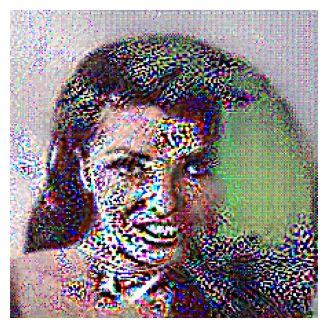

In [14]:
display_tensor_img(y_hat)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


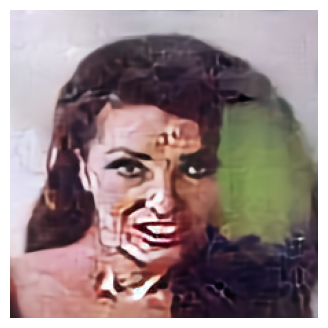

In [15]:
output = net.forward(y_hat)['x_hat']
display_tensor_img(output)